# Model clinical trajectories from longitudinal data
* **Input:** 
    1. Clinical data - csv / tables    


* **functions**
    1. Generate trajectory templates
    2. Assign trajectory labels to new subjects


* **user parameters**
    1. Number of timepoints for modeling
    2. Number of clusters (post-hoc) 

In [1]:
# Basic lib imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from typing import List
from scipy import stats
import os
import PIL
import pathlib
import PIL.Image
import seaborn as sns
import numpy
from scipy.spatial.distance import pdist
%matplotlib inline

In [2]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import euclidean_distances


def define_clusters(df,feat_cols,n_clusters, plot_clusters, permute):
    # Returns orginal dataframe with cluster assignments, where df = dataframes
    # Returns percentage overlap of clusters for each permuted sample
    # The amount of n_clusters represents the amount of trajectories
    if plot_clusters:
        g = sns.clustermap(df[feat_cols], row_cluster=True, col_cluster=False, 
                           metric = 'euclidean', method='ward', 
                           xticklabels=True, yticklabels=False)    
    #creates linkage map for scipy to perofrm heirarchical clustering
    Z = sch.linkage(pdist(df[feat_cols]), metric ='euclidean',method='ward')   
    T = sch.fcluster(Z, n_clusters, 'maxclust')      
    df['T'] = T
    # mean trajectory templates 
    traj_templates = {}
    for traj in range(1,n_clusters+1):
        traj_templates[traj] = np.round(np.mean(df[df['T']==traj][feat_cols].
                                                values,axis=0),3)
    #Stability 
    if permute:    
        permute_ci = compute_stability(df,feat_cols,n_clusters,permute)
    else:
        permute_ci = False
            
    return df, traj_templates, permute_ci

# Compute stability of cluster based on overlap of subjects that belong to same cluster during permutations
def compute_stability(_df,feat_cols,n_clusters, permute):
    permute_ci = [] #summary stat computed over all clusters for all permutations
    for p in range(permute):                     
        # Create two samples
        df_samp_1 = _df.sample(frac=0.8)            
        df_samp_2 = _df.sample(frac=0.8)     
        sub_samp_1 = df_samp_1['sub'].values
        sub_samp_2 = df_samp_2['sub'].values            

        # Generate two permuted solutions
        Z_samp = sch.linkage(pdist(df_samp_1[feat_cols]), metric ='euclidean',method='ward')
        T_samp_1 = sch.fcluster(Z_samp, n_clusters, 'maxclust')      
        Z_samp = sch.linkage(pdist(df_samp_2[feat_cols]), metric ='euclidean',method='ward')            
        T_samp_2 = sch.fcluster(Z_samp, n_clusters, 'maxclust')      

        #Find overlap between subjects that belong to same cluster
        cluster_intersect = [] #list of all cluster intersections during permutation
        for c1 in range(1,n_clusters+1):
            ci = [] # cluster intersection within a single permutation
            for c2 in range(1,n_clusters+1): #Compare with every cluster from second permuted sample
                ci.append(len(set(sub_samp_1[T_samp_1==c1])&set(sub_samp_2[T_samp_2==c2])))

            #Since cluster number/name have no particular order, 
            # we are looking for maximum overlap between each cluster solution
            cluster_intersect.append(np.max(ci))

        # Fraction of subjects maintained their cluster membership in a permuted sample
        permute_ci.append(np.sum(cluster_intersect)/len(df_samp_1))
        
    return permute_ci

# TODO
# Assign cluster membership to a new subject based on proximity to available cluster templates
def assign_clusters(_df,feat_cols,traj_templates):
    assert len(feat_cols) == len(traj_templates[1]) 
    subject_scores = _df[feat_cols].values
    
    # Maintain order of template names (A,B,C...)
    traj_names = np.tile(np.array(list(traj_templates.keys())),(len(subject_scores),1))
    #print(traj_names)
    traj_vals = np.array(list(traj_templates.values()))
    dst = euclidean_distances(subject_scores,traj_vals) #pairwise distances from each subject to each template
    _df['prox_vec'] = list(np.round(dst/np.sum(dst,1)[:,None],3))
    _df['T'] = traj_names[np.arange(len(traj_names)),np.argmin(dst,axis=1)] #the closest templates        
    
    return _df


## Importing Functions to Help with Data

In [3]:
# UTILITY FUNCTIONS FOR EDA

# Drops any column not in columns_to_keep
def drop_columns(df: pd.DataFrame, columns_to_keep: np.array) -> pd.DataFrame:
    columns_to_drop = df.columns[np.isin(df.columns, columns_to_keep, invert=True)]
    return df.drop(columns_to_drop, axis=1)

# Wraps pandas merge functions to inform of the number of extra rows created on each merge
def merge_dfs(left_df: pd.DataFrame, 
              right_df: pd.DataFrame, 
              right_columns: List[str], 
              on: List[str], 
              how: str='outer') -> pd.DataFrame:
    
    # merge
    df = pd.merge(left_df, 
                  right_df[right_columns],
                  on=on,
                  how=how)

    n_added_rows = df.shape[0] - left_df.shape[0]
    print("Number of rows increased by : {}".format(n_added_rows))
    return df

# filter failed screenings for ADNI1 phase
def drop_adni1_failed_screenings(df):
    return df[df['VISCODE'] != 'f']
    
# in ADNI1 we do not have screening visites registered, only basline
def swap_adni1_sc_for_bl(df):
    df.loc[(df['VISCODE']=='sc')&(df['Phase']=='ADNI1'), ['VISCODE', 'VISCODE2']] = 'bl'
    return df

# combines the above 2 functions
def adapt_adni1_viscodes(df):
    return swap_adni1_sc_for_bl(drop_adni1_failed_screenings(df))

# replaces -4 and -1 (adni for missing values) with NaN
def replace_missing_values_with_nan(df):
    return df.replace([-4, -1, '-4', '-1'], np.NaN)
    
### Functions to separate patients per study ###
def get_adni1_patients_rids(df):
    return df.loc[(df['Phase'] == 'ADNI1')
                  & (df['VISCODE'] == 'bl')
                  & (df['RGCONDCT'] == 1), 'RID'].values

def get_adnigo_patients_rids(df):
    return df.loc[(df['Phase'] == 'ADNIGO')
                  & (df['VISCODE'] == 'bl')
                  & (df['PTSTATUS'] == 1), 'RID'].values

def get_adni2_patients_rids(df):
    return df.loc[(df['Phase'] == 'ADNI2')              
                  & (df['VISCODE'] == 'v03')
                  & (df['RGSTATUS'] == 1)
                  & (df['DXCHANGE'].notnull()), 'RID'].values

def get_adni1go_patients_rids(df):
    return df.loc[(df['Phase'] == 'ADNIGO')                  
                  & (df['PTSTATUS'] == 1)
                  & (df['RID'] < 2000)
                  & (df['DXCHANGE'].notnull()), 'RID'].values

def get_adni1go2_patients_rids(df):
    return df.loc[(df['Phase'] == 'ADNI2')
                  & (df['VISCODE'] == 'v06')
                  & (df['RGSTATUS'] == 1)
                  & (df['DXCHANGE'].notnull())
                  & (df['RID'] < 2000), 'RID'].values

def get_adnigo2_patients_rids(df):
    return df.loc[(df['Phase'] == 'ADNI2')
                  & (df['VISCODE'] == 'v06')
                  & (df['RGSTATUS'] == 1)
                  & (df['DXCHANGE'].notnull())
                  & (df['RID'] < 5000)
                  & (df['RID'] >= 2000), 'RID'].values

def separate_adni_patients_per_phases(df):  
    adni1_rids = get_adni1_patients_rids(df)
    print('ADNI1 patients: ' + str(adni1_rids.shape))

    adnigo_rids = get_adnigo_patients_rids(df)
    print('ADNIGO patients: ' + str(adnigo_rids.shape))
    
    adni2_rids = get_adnig2_patients_rids(df)
    print('ADNI2 patients: ' + str(adni2_rids.shape))

    adni1_go_rids = get_adni1go_patients_rids(df)
    print('ADNI1->ADNIGO patients: ' + adni1_go_rids.shape)

    adni1_go_2_rids = get_adni1go2_patients_rids(df)
    print('ADNI1->ADNIGO->ADNI2 patients: ' + adni1_go_2_rids.shape)

    adnigo_2_rids = get_adnigo2_patients_rids(df)
    print('ADNIGO->ADNI2 patients: ' + adnigo_2_rids.shape)

    all_valid_rids = np.append(np.append(adni1_rids, adnigo_rids), adni2_rids)
    print(all_valid_rids.shape)

    return df, adni1_rids, adnigo_rids, adni2_rids, adni1_go_rids, adni1_go_2_rids, adnigo_2_rids, all_valid_ids

def process_diagnosis(df: pd.DataFrame) -> pd.DataFrame:
    # adapt values from ADNI 1 to ADNI2/3 style
    df.loc[(dx_df['DXCONV']==0) & (dx_df['DXCURREN']==1), 'DXCHANGE'] = 1
    df.loc[(dx_df['DXCONV']==0) & (dx_df['DXCURREN']==2), 'DXCHANGE'] = 2
    df.loc[(dx_df['DXCONV']==0) & (dx_df['DXCURREN']==3), 'DXCHANGE'] = 3
    df.loc[(dx_df['DXCONV']==1) & (dx_df['DXCONTYP']==1), 'DXCHANGE'] = 4
    df.loc[(dx_df['DXCONV']==1) & (dx_df['DXCONTYP']==3), 'DXCHANGE'] = 5
    df.loc[(dx_df['DXCONV']==1) & (dx_df['DXCONTYP']==2), 'DXCHANGE'] = 6
    df.loc[(dx_df['DXCONV']==2) & (dx_df['DXREV']==1), 'DXCHANGE'] = 7
    df.loc[(dx_df['DXCONV']==2) & (dx_df['DXREV']==2), 'DXCHANGE'] = 8
    df.loc[(dx_df['DXCONV']==2) & (dx_df['DXREV']==3), 'DXCHANGE'] = 9
    
    # unify all values and create DX column
    # DXCHANGE=1,7,9 -> Normal (NL)
    # DXCHANGE=2,4,8 -> Mild Cognitive Impairment (MCI)
    # DXCHANGE=3,5,6 -> Dementia (D), we are going to consider it as Alzehimer's Disease (AD)    
    df.loc[(df['DXCHANGE'].isin([1,7,9])), 'DX'] = 'NL'
    df.loc[(df['DXCHANGE'].isin([2,4,8])), 'DX'] = 'MCI'
    df.loc[(df['DXCHANGE'].isin([3,5,6])), 'DX'] = 'AD'
    
    # drop undesired columns
    # VISCODE: original visit code
    # VISCODE2: visit codes transformed to be homogeneus
    columns_to_keep = ['Phase', 'RID', 'VISCODE', 'VISCODE2', 'DX']
    df = drop_columns(df, columns_to_keep)
    
    return df

# Play with number of clusters -> check stability 

C:\Users\aayus\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (8,58,59,60,61,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


123.23
[16.33, 19.33, 17.67, 17.0, 13.67, -4.0, 56.0, -4.0, 2.0, 0.0]
[12.   12.67 10.33 14.    8.33  6.67 13.   13.   14.  ]
Printing final_subjects
Total Subjects Found
69
Printing All Subjects in final_subjects
[42, 107, 108, 112, 116, 126, 142, 160, 161, 169, 178, 214, 217, 256, 276, 285, 289, 292, 294, 307, 331, 361, 384, 408, 539, 546, 563, 572, 626, 644, 658, 668, 702, 709, 722, 729, 752, 800, 802, 835, 906, 914, 919, 922, 952, 978, 994, 1032, 1045, 1066, 1074, 1078, 1097, 1122, 1130, 1155, 1187, 1243, 1246, 1268, 1269, 1300, 1318, 1326, 1346, 1352, 1414, 1418, 1427]
printing abc
[]


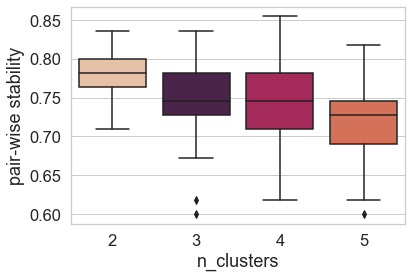

In [43]:
import csv
#simulated data
csv_path = "MMSE.csv"
dx_df = pd.read_csv('DXSUM_PDXCONV_ADNIALL.csv')
adas_df = pd.read_csv('ADAS_ADNI1.csv')
adas2_df = pd.read_csv('ADAS_ADNIGO23.csv')
mmse_df = pd.read_csv(csv_path)
#print(mmse_df.columns)
adni_merge_df = process_diagnosis(dx_df)
#display(adni_merge_df.head())
#print(adni_merge_df.shape)
num_patients = 8000
num_timepoints = 9
subjects_needed= list()
timepoints = ["bl", "m06", "m12", "m18", "m24", "m36", "m48", "m60", "m72"]
count = numpy.full((num_patients,num_timepoints), -4.0)
t = float("123.23")
print(t)

vals = list()

#double check later that you row[21] is correct
with open('ADASSCORES.csv', 'rt') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        if(row[1] == 'RID'):
            continue
        index = 0
        for i in range(len(timepoints)):
            if(timepoints[i] == row[3]):
                index = i
        vals.append(float(row[21]))
        rid = int(row[1])
        if(count[rid][index] == -4.0):
            count[rid][index] = float(row[21])
        else:
            count[rid][index] = min(count[rid][index], float(row[21]))
print(vals[0:10])
counter = 0
vals1 = list()
with open('ADAS_ADNIGO23.csv', 'rt') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        if(row[1] == 'ID'):
            continue
        index = 0
        for i in range(len(timepoints)):
            if(timepoints[i] == row[5]):
                index = i
        rid = int(row[2])
        if(row[119] == ''):
            continue
        if(count[rid][index] == -4.0):
            count[rid][index] = float(row[119])
        else:
            count[rid][index] = min(count[rid][index], float(row[119]))
        counter+=1
#     print(counter)
    counter+=1

print(count[722])

#print(subjects_needed[0:12])
compiled_ADAS = list()
for i in range(len(count)):
    flag = 0
    for j in range(len(count[i])):
        if(count[i][j] == -4):
            flag = 1
    if(flag == 0):
        compiled_ADAS.append(i)

compiled_ADAS.sort()
# print("Printing found_ADAS")
# print("Total Subjects Found")
# print(len(compiled_ADAS))
# print("Printing All Subjects in found_ADAS")
# print((compiled_ADAS[0:60]))


timepoints1 = ["sc", "m06", "m12", "m18", "m24", "m36", "m48", "m60", "m72"]
subjects_needed_mmse = list()
count1 = numpy.full((num_patients,num_timepoints), -4)
with open('MMSE.csv', 'rt') as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        if(row[1] == 'ID'):
            continue
        index = 0
        for i in range(len(timepoints1)):
            if(timepoints[i] == row[5]):
                index = i
#         print(row[56])
        if(row[56] == ''):
            continue
        count1[int(row[2])][index] = max(count1[int(row[2])][index], int(row[56]))
        
compiled_mmse = list()
for i in range(len(count1)):
    flag = 0
    for j in range(len(count1[i])):
        if(count1[i][j] == -4):
            flag = 1
    if(flag == 0):
        compiled_mmse.append(i)

compiled_mmse.sort()
# print()
# print()
# print("Printing found_MMSE")
# print("Total Subjects Found")
# print(len(compiled_mmse))
# print("Printing First 60 Subjects in found_MMSE")
# print((compiled_mmse[0:60]))
        
# mmse_df = adapt_adni1_viscodes(mmse_df)
# mmse_df = replace_missing_values_with_nan(mmse_df)
# mmse_df = mmse_df[mmse_df['MMSCORE'].notnull()]
# adni_merge_df = merge_dfs(adni_merge_df, 
#                           mmse_df,
#                           ['RID', 'Phase', 'VISCODE', 'VISCODE2', 'MMSCORE'],
#                           ['RID', 'Phase', 'VISCODE', 'VISCODE2'])
# display(adni_merge_df.head())
# adni_merge_df.shape
final_subjects = list()
for subject in compiled_ADAS:
    if(subject in compiled_mmse):
        final_subjects.append(subject)
        
adas_timepoint_data = numpy.full((len(final_subjects),num_timepoints), 0.0)
mmse_timepoint_data = numpy.full((len(final_subjects),num_timepoints), 0.0)


#going to deidentify below and remove subject rid

index = 0
for patient in final_subjects:
    for i in range(num_timepoints):
        adas_timepoint_data[index][i] = float(count[patient][i])
        mmse_timepoint_data[index][i] = (count1[patient][i])
    index += 1
        
        
#print(adas_timepoint_data)
print("Printing final_subjects")
print("Total Subjects Found")
print(len(final_subjects))
print("Printing All Subjects in final_subjects")
print((final_subjects))        

n_subs = len(final_subjects)
n_feat = num_timepoints
# a = np.random.rand(n_subs,n_feat)
# b = 2*np.random.rand(n_subs,n_feat)
# c = 4*np.random.rand(n_subs,n_feat)
# d = np.vstack((a,b,c))
# print(d)
#df = pd.DataFrame(data=d)
# print(df)
abc = list()
for subject in final_subjects:
    if(count1[subject][0] < 15):
        abc.append(subject)
print("printing abc")
print(abc)   

df = pd.DataFrame(data=mmse_timepoint_data)
df['sub'] = range(len(df))
feat_cols = list(range(num_timepoints))

plot_clusters = False # To avoid messy plots, only plot when you have a single n_clusters value (see below)
permute = 100

# Iterate through different cluster solutions
cluster_list = [2,3,4,5]
stab = np.zeros((len(cluster_list),permute))
for n,n_clusters in enumerate(cluster_list):
    df,traj_templates, permute_ci = define_clusters(df,feat_cols,n_clusters,plot_clusters,permute)
    stab[n,:] = permute_ci

# Plot cluster stability
sns.set(font_scale=1.5)
my_pal = {"#501F4F", "#b81654", "#e86645", "#f2bd9d"}
with sns.axes_style("whitegrid"):
    g2 = sns.boxplot(data=pd.DataFrame(stab.T,columns=cluster_list),orient='v', palette = my_pal)
    plt.xlabel('n_clusters')
    plt.ylabel('pair-wise stability')


# Pick a cluster solution (n_cluster)

[0, 1, 2, 3, 4, 5, 6, 7, 8]
Mean values per cluster, i.e. trajectory templates
{1: array([28.939, 28.636, 29.121, 28.909, 29.121, 28.909, 28.667, 28.333,
       27.545]), 2: array([26.833, 25.806, 25.5  , 25.111, 24.472, 23.25 , 22.222, 21.056,
       18.528])}


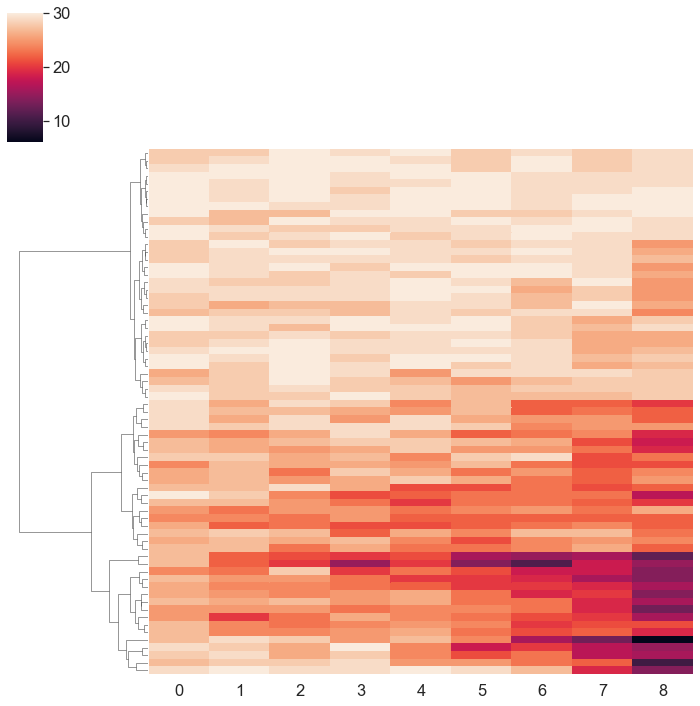

In [44]:
# Pick a cluster solution (n_cluster)
print(feat_cols)
n_clusters = 2
permute = False # No need to permute now 
plot_clusters = True
df,traj_templates, permute_ci = define_clusters(df,feat_cols,n_clusters,plot_clusters,permute)

#print(df)

print('Mean values per cluster, i.e. trajectory templates')
print(traj_templates)

C:\Users\aayus\anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\aayus\anaconda3\lib\site-packages\seaborn\categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


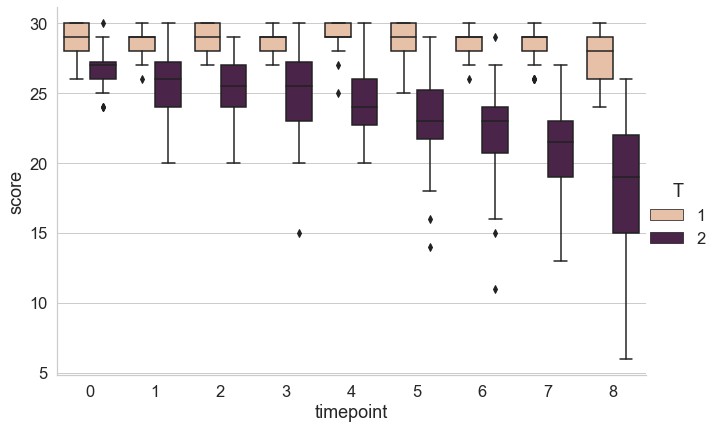

In [45]:
# Plot: trajectory score distributions 
traj_df = pd.melt(df, id_vars=['sub','T'],value_vars=feat_cols,var_name='timepoint',value_name='score')
#print(traj_df['T'])
my_pal1 = {"#501F4F", "#b81654", "#f2bd9d"}
#"#f2bd9d", "", "#e86645",
with sns.axes_style("whitegrid"):
    g1 = sns.factorplot(y='score',x='timepoint',hue='T',data=traj_df, kind='box',size=6,aspect=1.5, palette = my_pal1 )
#     g1.set_xticklabels(rotation=30)

# Assign cluster to new set of subjects

In [22]:
# Sim data (from same distribution as before)
n_subs = 10
a = np.random.rand(n_subs,n_feat)
b = 2*np.random.rand(n_subs,n_feat)
c = 4*np.random.rand(n_subs,n_feat)
d = np.vstack((a,b,c))
df = pd.DataFrame(data=d)

df['sub'] = range(len(df))
feat_cols = list(range(n_feat))

# Assign based on Euclidean proximity (need to be consistent wit)
df = assign_clusters(df,feat_cols,traj_templates)
df

,0,1,2,3,4,5,6,7,8,sub,prox_vec,T
0,0.622480,0.430402,0.435318,0.994959,0.356791,0.006301,0.467585,0.851431,0.569616,0,"[0.176, 0.34, 0.483]",1
1,0.420970,0.323523,0.502750,0.646129,0.731810,0.342822,0.129374,0.089826,0.487527,1,"[0.177, 0.34, 0.483]",1
2,0.560385,0.863429,0.709567,0.577402,0.933244,0.758472,0.869390,0.317163,0.358936,2,"[0.175, 0.34, 0.484]",1
3,0.168062,0.181165,0.018101,0.358859,0.021331,0.178358,0.507605,0.058227,0.639471,3,"[0.179, 0.34, 0.481]",1
4,0.215672,0.119500,0.812044,0.964930,0.506944,0.116388,0.029358,0.914656,0.626837,4,"[0.177, 0.34, 0.483]",1
5,0.452371,0.589406,0.407393,0.150405,0.646426,0.221995,0.975131,0.263556,0.478667,5,"[0.177, 0.34, 0.483]",1
6,0.051208,0.928038,0.739339,0.080898,0.607430,0.215454,0.487054,0.762770,0.241922,6,"[0.177, 0.34, 0.483]",1
7,0.898616,0.442596,0.375220,0.253698,0.293936,0.533146,0.033327,0.433091,0.584241,7,"[0.177, 0.34, 0.483]",1
8,0.616575,0.695669,0.596124,0.926062,0.845926,0.700369,0.302063,0.107650,0.964495,8,"[0.175, 0.34, 0.484]",1
9,0.948312,0.204246,0.356466,0.197641,0.998855,0.817528,0.833334,0.017584,0.540344,9,"[0.176, 0.34, 0.483]",1
